In [46]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, r2_score

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
train.shape, test.shape

((28200, 22), (12086, 21))

# EDA

In [3]:
wind = 'windmill_generated_power(kW/h)'
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [4]:
train = train[~train[wind].isnull()]
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    271
atmospheric_temperature(°C)       3422
shaft_temperature(°C)                2
blades_angle(°)                    212
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2690
area_temperature(°C)                 0
windmill_body_temperature(°C)     2352
wind_direction(°)                 5058
resistance(ohm)                      1
rotor_torque(N-m)                  567
turbine_status                    1747
cloud_level                        272
blade_length(m)                   5057
blade_breadth(m)                     0
windmill_height(m)                 538
windmill_generated_power(kW/h)       0
dtype: int64

# Features

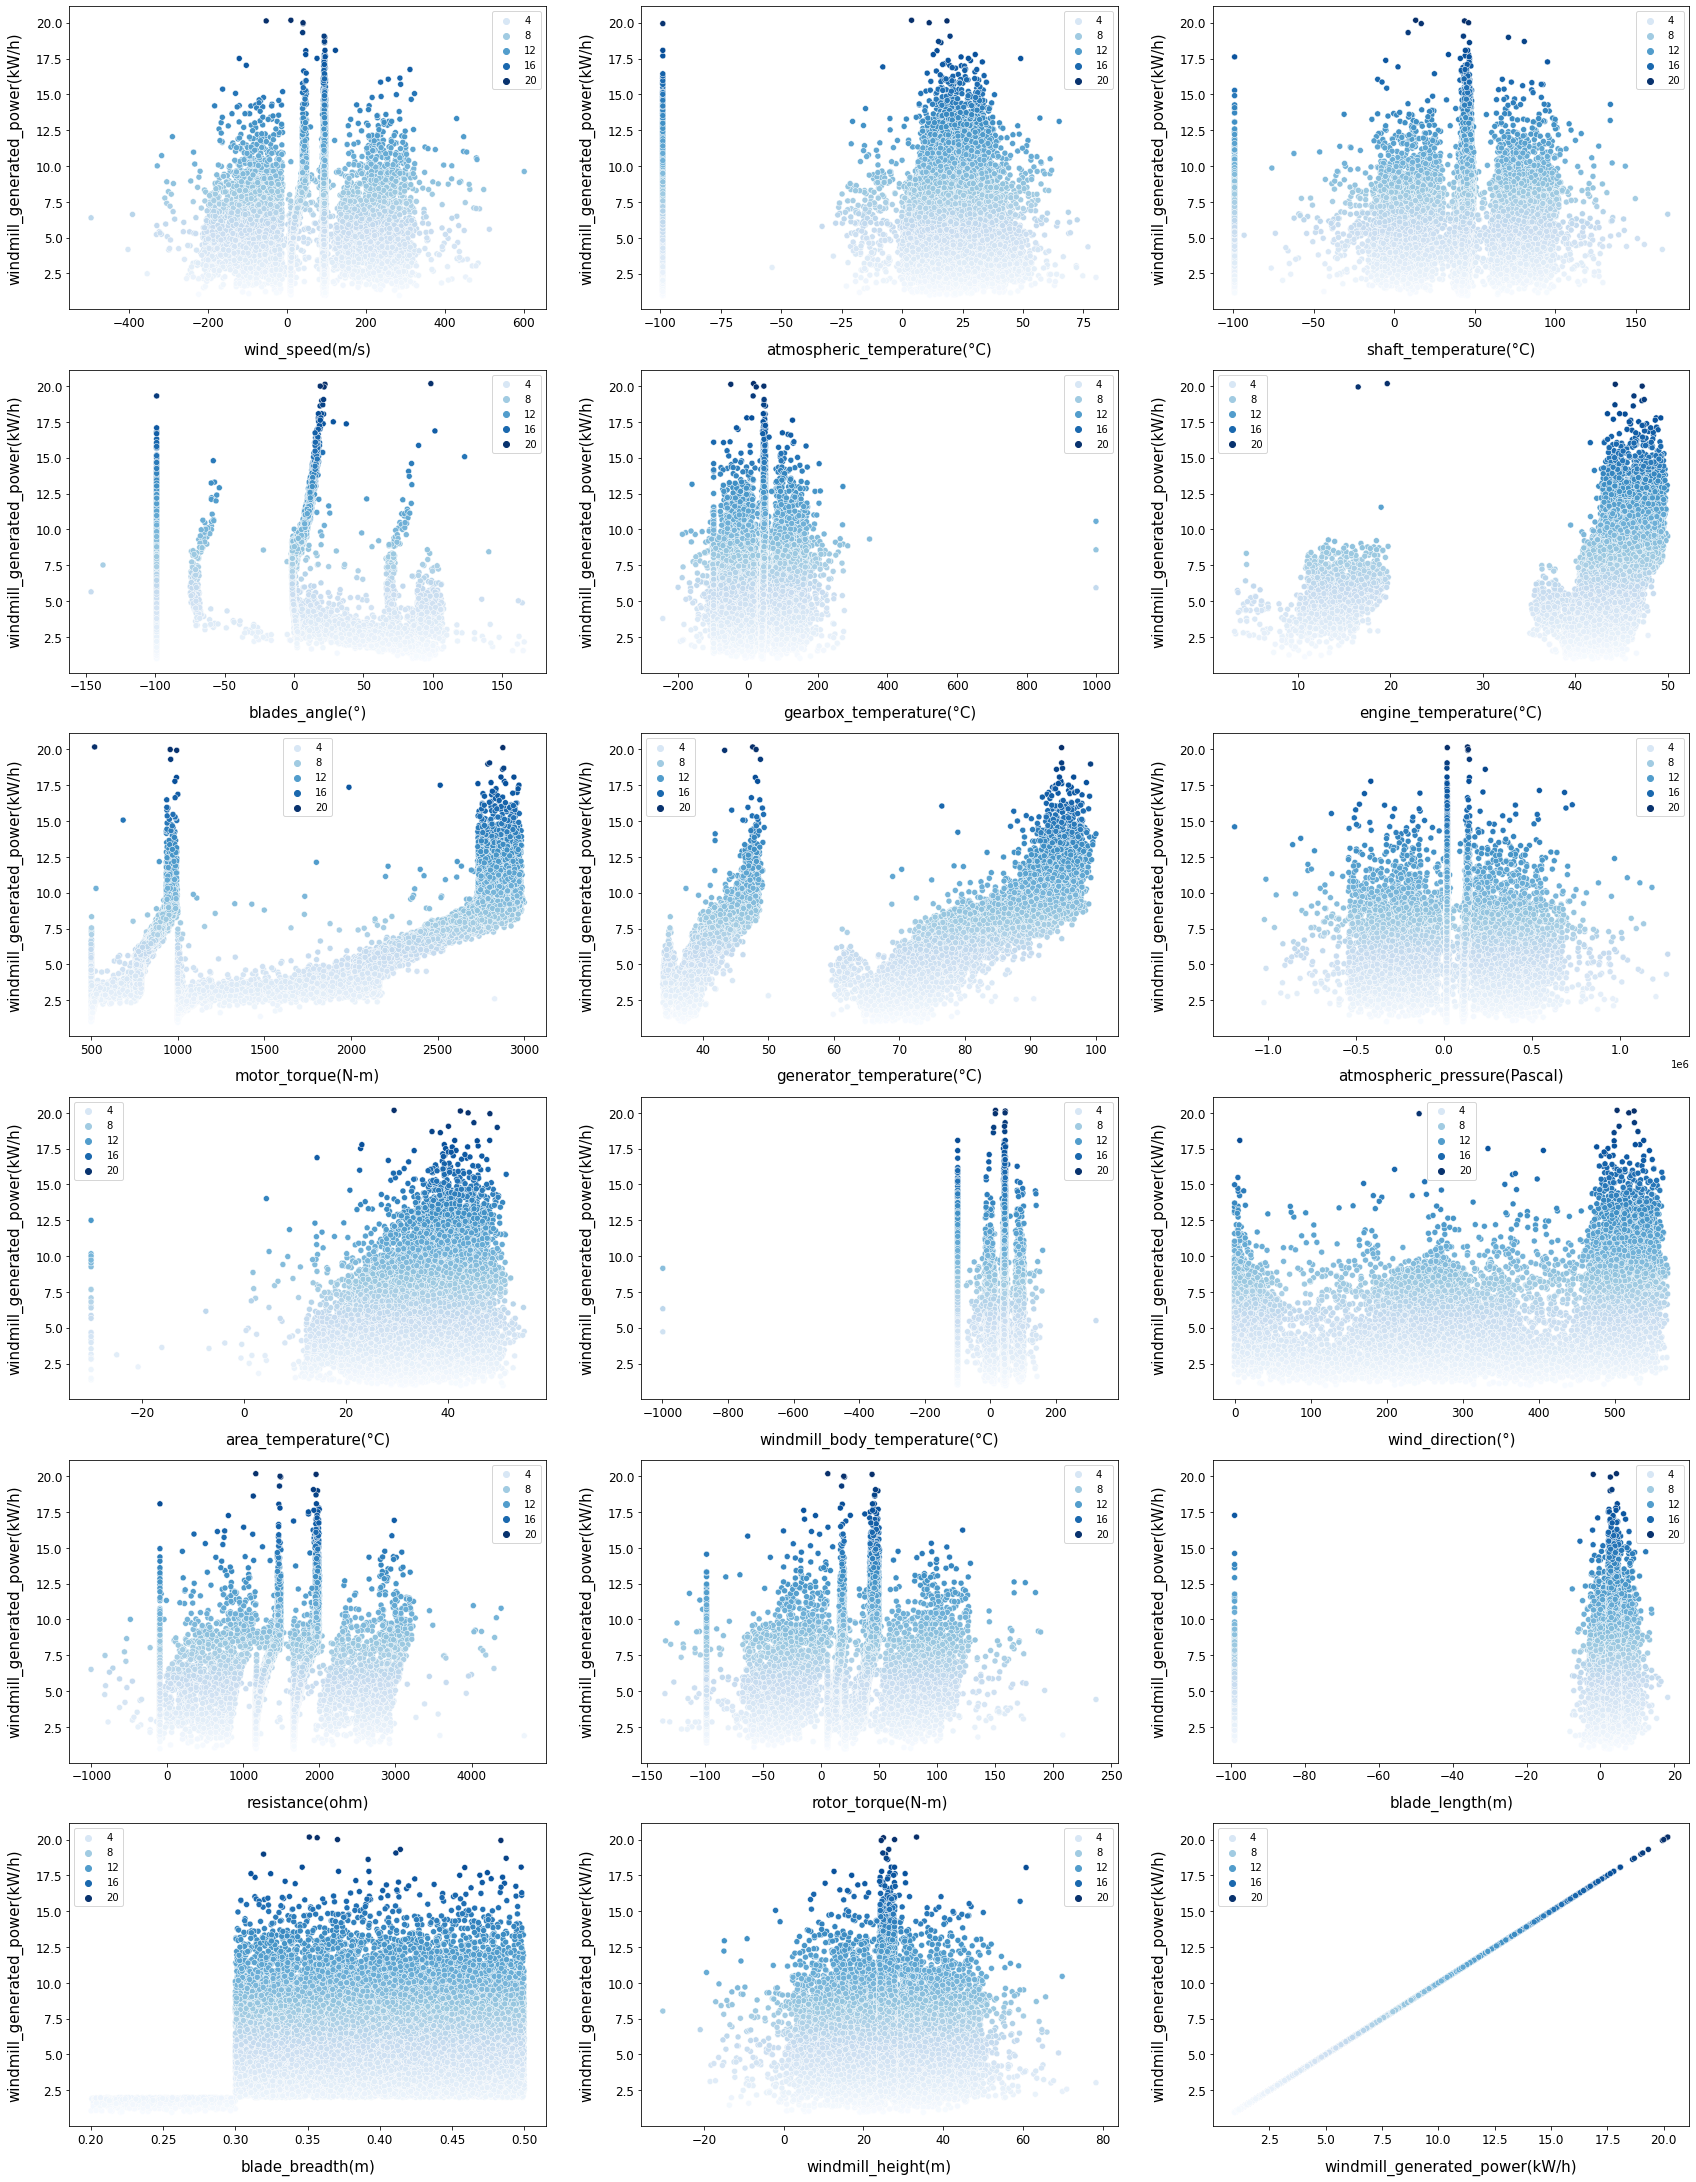

In [5]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 48))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y=wind, hue=wind, palette='Blues', data=train)
        
    plt.xlabel(f'{feature}', size=15,labelpad=12.5)
    plt.ylabel(wind, size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

<AxesSubplot:>

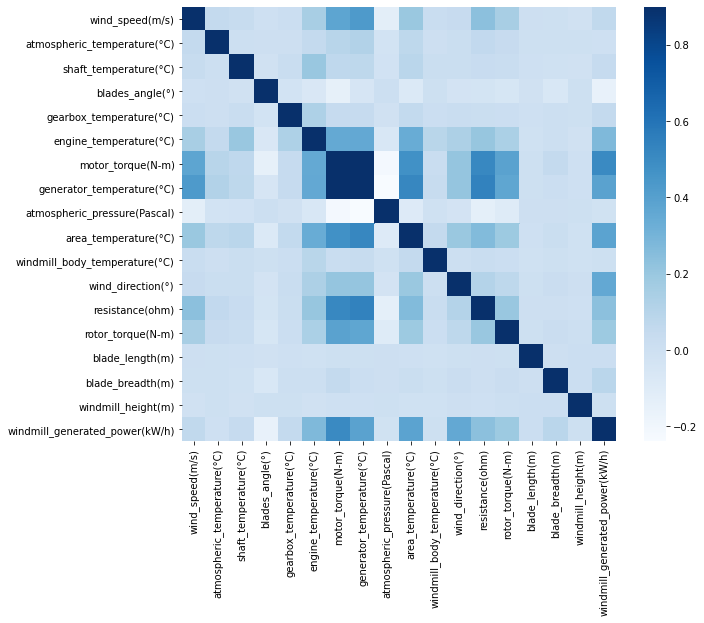

In [6]:
corr = train.corr()
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [7]:
train = train.drop(['tracking_id', 'datetime'], axis=1)
test = test.drop(['tracking_id', 'datetime'], axis=1)

# Feature Engineering

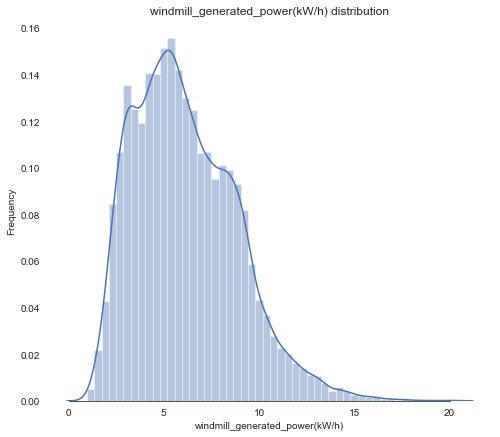

In [8]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train[wind], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel=wind)
ax.set(title=f"{wind} distribution")
sns.despine(trim=True, left=True)
plt.show()

In [9]:
# Skew and kurt
print("Skewness: %f" % train[wind].skew())
print("Kurtosis: %f" % train[wind].kurt())

Skewness: 0.688935
Kurtosis: 0.437043


In [10]:
# log(1+x) transform
train[wind] = np.log1p(train[wind])


 mu = 1.89 and sigma = 0.39



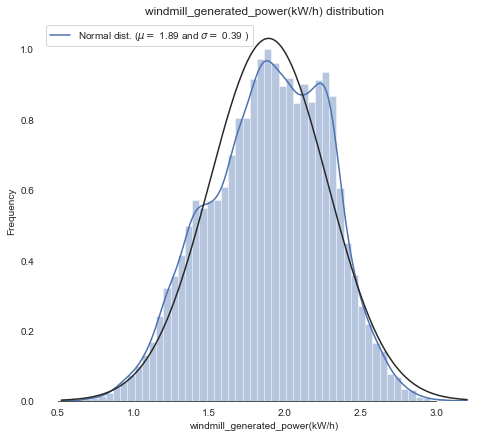

In [11]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train[wind] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[wind])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel=wind)
ax.set(title=f"{wind} distribution")
sns.despine(trim=True, left=True)

plt.show()

### Outliers

In [12]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

train = cap_data(train)
train

capping the  wind_speed(m/s)
capping the  atmospheric_temperature(°C)
capping the  shaft_temperature(°C)
capping the  blades_angle(°)
capping the  gearbox_temperature(°C)
capping the  engine_temperature(°C)
capping the  motor_torque(N-m)
capping the  generator_temperature(°C)
capping the  atmospheric_pressure(Pascal)
capping the  area_temperature(°C)
capping the  windmill_body_temperature(°C)
capping the  wind_direction(°)
capping the  resistance(ohm)
capping the  rotor_torque(N-m)
capping the  turbine_status
capping the  cloud_level
capping the  blade_length(m)
capping the  blade_breadth(m)
capping the  windmill_height(m)
capping the  windmill_generated_power(kW/h)


,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,2.049822
1,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,1.941081
2,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,1.354376
3,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,2.682344
4,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,1.508307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,90.898875,19428.725079,45.429230,44.242269,536.153413,1980.861921,45.909054,BB,Medium,2.774335,0.418299,24.590801,2.359715
28196,94.196738,24.034329,42.068979,-99.000000,44.285153,43.487939,2207.882276,72.244645,16596.485400,25.142681,43.616412,354.239825,1712.840457,36.974913,BB,Low,-3.250989,0.461531,26.051604,1.708775
28197,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,94.814637,19083.881449,45.129442,43.576510,534.209913,1951.728713,88.319152,D,Medium,NaN,0.380264,28.533850,2.492924
28198,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,90.144418,18360.785707,45.603927,44.973415,551.899831,1968.917692,47.562627,BCB,Low,3.001855,0.346447,47.747269,2.339229


In [13]:
# Split features and labels
train_labels = train[wind].reset_index(drop=True)
train_features = train.drop([wind], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(40079, 19)

# Missing Values

In [14]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('wind_direction(°)', 18.01),
 ('blade_length(m)', 17.89),
 ('atmospheric_temperature(°C)', 12.1),
 ('atmospheric_pressure(Pascal)', 9.58),
 ('windmill_body_temperature(°C)', 8.18),
 ('turbine_status', 6.35),
 ('rotor_torque(N-m)', 2.12),
 ('windmill_height(m)', 1.98),
 ('wind_speed(m/s)', 0.99),
 ('cloud_level', 0.99)]

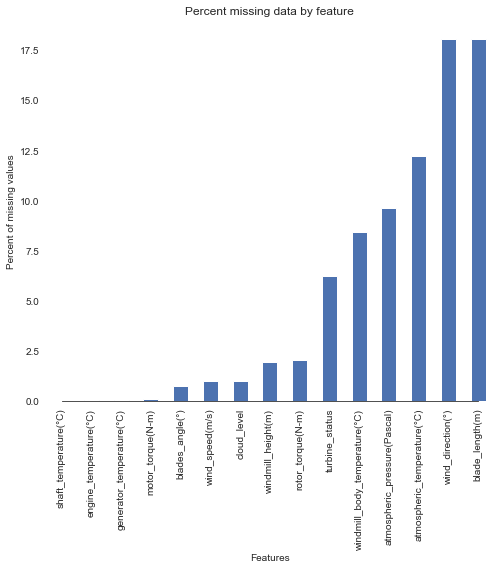

In [15]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [16]:
# Let's fill up

all_features['turbine_status'] = all_features['turbine_status'].fillna(all_features['turbine_status'].mode()[0])
all_features['cloud_level'] = all_features['cloud_level'].fillna(all_features['cloud_level'].mode()[0])

for i in all_features.columns:
    if all_features[i].isnull().sum()>0:
        mean = all_features[i].mean()
        all_features[i].replace(np.nan, mean, inplace=True)

In [17]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('wind_speed(m/s)', 0.0),
 ('atmospheric_temperature(°C)', 0.0),
 ('shaft_temperature(°C)', 0.0),
 ('blades_angle(°)', 0.0),
 ('gearbox_temperature(°C)', 0.0),
 ('engine_temperature(°C)', 0.0),
 ('motor_torque(N-m)', 0.0),
 ('generator_temperature(°C)', 0.0),
 ('atmospheric_pressure(Pascal)', 0.0),
 ('area_temperature(°C)', 0.0)]

### Skewed Features

In [18]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

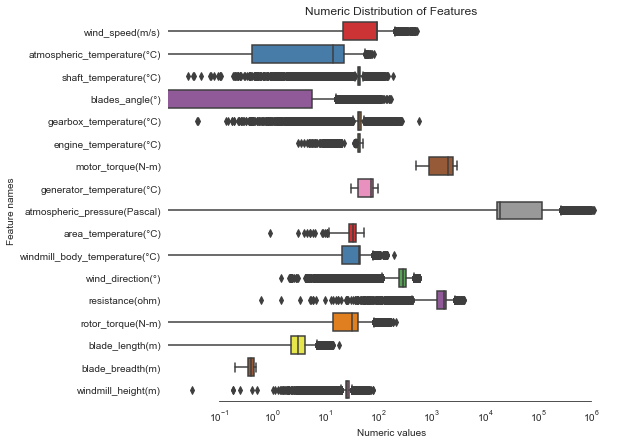

In [19]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [20]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 0 numerical features with Skew > 0.5 :


wind_direction(°)               0.191094
motor_torque(N-m)               0.033141
atmospheric_pressure(Pascal)    0.017687
windmill_height(m)             -0.010710
wind_speed(m/s)                -0.125487
blade_breadth(m)               -0.156047
area_temperature(°C)           -0.165647
generator_temperature(°C)      -0.192356
gearbox_temperature(°C)        -0.317059
blades_angle(°)                -0.686110
dtype: float64

### No need to do this then. Cheers!

In [21]:
# # Normalize skewed features
# for i in skew_index:
#     all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [22]:
# # Let's make sure we handled all the skewed values
# sns.set_style("white")
# f, ax = plt.subplots(figsize=(8, 7))
# ax.set_xscale("log")
# ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
# ax.xaxis.grid(False)
# ax.set(ylabel="Feature names")
# ax.set(xlabel="Numeric values")
# ax.set(title="Numeric Distribution of Features")
# sns.despine(trim=True, left=True)

In [23]:
# crear features
all_features['blade_area'] = all_features['blade_length(m)'] * all_features['blade_breadth(m)']

# Feature transformations

In [24]:
# def logs(res, ls):
#     m = res.shape[1]
#     for l in ls:
#         res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
#         res.columns.values[m] = l + '_log'
#         m += 1
#     return res

# log_features = []
# for i in all_features.columns:
#     if all_features[i].dtypes in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
#         log_features.append(i)
# print(log_features)
# # all_features = logs(all_features, log_features)

In [25]:
all_features
all_features.isnull().sum()

wind_speed(m/s)                  0
atmospheric_temperature(°C)      0
shaft_temperature(°C)            0
blades_angle(°)                  0
gearbox_temperature(°C)          0
engine_temperature(°C)           0
motor_torque(N-m)                0
generator_temperature(°C)        0
atmospheric_pressure(Pascal)     0
area_temperature(°C)             0
windmill_body_temperature(°C)    0
wind_direction(°)                0
resistance(ohm)                  0
rotor_torque(N-m)                0
turbine_status                   0
cloud_level                      0
blade_length(m)                  0
blade_breadth(m)                 0
windmill_height(m)               0
blade_area                       0
dtype: int64

In [26]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = []
for i in all_features.columns:
    if (all_features[i].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']) and ('log' in i):
        squared_features.append(i)
        
all_features = squares(all_features, squared_features)
all_features

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),blade_area
0,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,20.821009,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,0.696452
1,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,20.821009,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,1.888317
2,95.484724,0.423187,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,0.822154
3,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,Low,4.857385,0.367140,24.287767,1.783340
4,10.722890,0.423187,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,2.226085,0.453374,27.971650,1.009248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40074,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1.340332
40075,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.226085,0.367823,24.793606,0.818804
40076,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,1.714632
40077,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,25.954207,A,Medium,2.247676,0.394680,24.591364,0.887113


# Encode: dummy variables

In [27]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(40079, 35)

In [28]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

# Recreate training and test sets

In [29]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((27993, 35), (27993,), (12086, 35))

# Train model

In [30]:
# Setup cross validation folds
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [31]:
# score = max(0, 100 * r2_score(y_test, y_pred))
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [32]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Train models
## Get cross validation scores for each model

In [33]:
# import re
# X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X

In [34]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.0760 (0.0023)


In [35]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.0772 (0.0023)


In [36]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.2429 (0.0036)


In [37]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.2730 (0.0031)


In [38]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.0684 (0.0026)


In [39]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.0734 (0.0028)


## Fit

In [40]:
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [42]:
for i in ['lightgbm', 'xgboost', 'svr', 'ridge', 'rf', 'gbr']:
# for i in ['svr', 'ridge', 'rf']:
    vars()[f'{i}_model_full_data'] = vars()[i].fit(X, train_labels)
    print(f'{i} done!')

lightgbm done!
xgboost done!
svr done!
ridge done!
rf done!
gbr done!


## Blending

In [62]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.05 * ridge_model_full_data.predict(X)) + \
            (0.05 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgboost_model_full_data.predict(X)) + \
            (0.15 * lightgbm_model_full_data.predict(X)) + \
            (0.2 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [61]:
y_pred_rf = stack_gen_model.predict(np.array(X))
blended_score_rf = rmsle(train_labels, y_pred_rf)
hacker_score_rf = max(0, 100 * r2_score(train_labels, y_pred_rf))
print(f'Train Data:\n RMSLE score = {blended_score_rf}\n HackerEarth Score = {hacker_score}')

Train Data:
 RMSLE score = 0.050335580695743
 HackerEarth Score = 93.92853053177828


In [63]:
# Get final precitions from the blended model
y_pred = blended_predictions(X)
blended_score = rmsle(train_labels, y_pred)
scores['blended'] = (blended_score, 0)

In [64]:
hacker_score = max(0, 100 * r2_score(train_labels, y_pred))
# scores['blended_hacker'] = (hacker_score, 0)
print(f'Train Data:\n RMSLE score = {blended_score}\n HackerEarth Score = {hacker_score}')

Train Data:
 RMSLE score = 0.06171177803249531
 HackerEarth Score = 97.40106460691122


# Identify best model

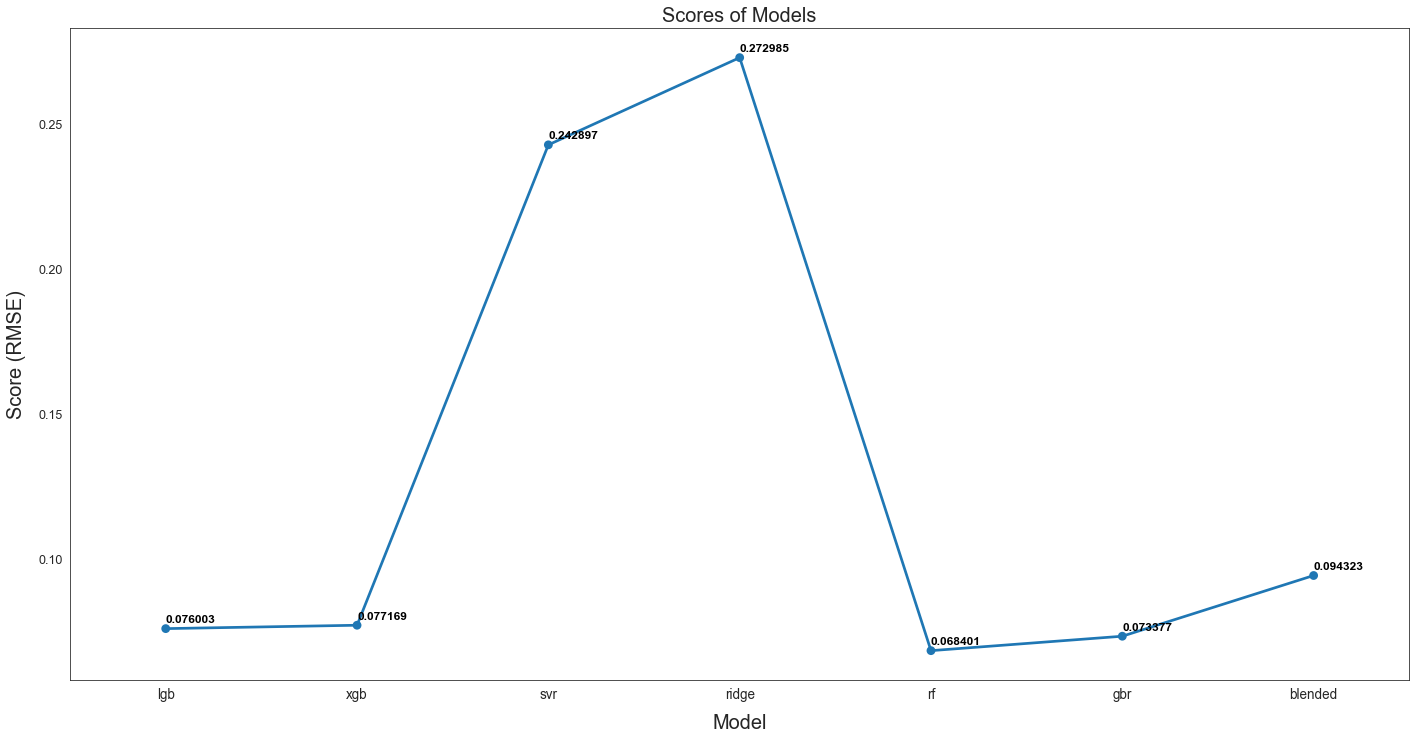

In [48]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

# Submision Time!

In [51]:
# Read in sample_submission dataframe
test2 = pd.read_csv("dataset/test.csv")
submission.shape

(12086, 21)

In [52]:
# Append predictions from blended models
y_pred_final = blended_predictions(X_test)
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
submission = pd.concat([test2[['tracking_id', 'datetime']], y_pred_final_df], axis=1)

In [55]:
submission.to_csv("submissions/submission_explore2.csv", index=False)
submission

In [56]:
# Fix outleir predictions
q1 = submission[wind].quantile(0.0045)
q2 = submission[wind].quantile(0.99)
submission[wind] = submission[wind].apply(lambda x: x if x > q1 else x*0.77)
submission[wind] = submission[wind].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submissions/submission_explore3.csv", index=False)